# Dissimilarity Matrix

In [1]:
import multiprocessing as mp
import os
import espargos_0007
import cluster_utils
import CRAP
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.csgraph import dijkstra
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from tqdm.auto import tqdm

2025-04-10 14:23:57.716757: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-10 14:23:57.737559: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-10 14:23:57.743902: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-10 14:23:57.759823: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-10 14:23:58.730577: W tensorflow/compiler/tf2

### Load Training Data, Clutter Channel and Position Estimates

In [2]:
# Loading all the datasets can take some time...
training_set = espargos_0007.load_dataset(espargos_0007.TRAINING_SET_ROBOT_FILES)

  0%|          | 0/3 [00:00<?, ?it/s]

Loading espargos-0007/espargos-0007-meanders-nw-se-1.tfrecords


I0000 00:00:1744295041.414649   32388 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1744295041.474436   32388 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1744295041.474831   32388 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1744295041.478962   32388 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Loading espargos-0007/espargos-0007-meanders-sw-ne-1.tfrecords


2025-04-10 14:24:24.373847: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loading espargos-0007/espargos-0007-randomwalk-1.tfrecords


In [3]:
for dataset in training_set:
    dataset_name = os.path.basename(dataset["filename"])
    dataset["clutter_acquisitions"] = np.load(os.path.join("clutter_channel_estimates", dataset_name + ".npy"))
    dataset["triangulation_position_estimates"] = np.load(os.path.join("triangulation_estimates", dataset_name + ".npy"))

In [4]:
for dataset in training_set:
    cluster_utils.cluster_dataset(dataset)

Clustering dataset espargos-0007/espargos-0007-meanders-nw-se-1.tfrecords


  0%|          | 0/174647 [00:00<?, ?it/s]

Clustering dataset espargos-0007/espargos-0007-meanders-sw-ne-1.tfrecords


  0%|          | 0/204711 [00:00<?, ?it/s]

Clustering dataset espargos-0007/espargos-0007-randomwalk-1.tfrecords


  0%|          | 0/103524 [00:00<?, ?it/s]

## ADP Dissimilarity Matrix

In [5]:
training_csi_reflected = []

for dataset in tqdm(training_set):
    print(f"Calculating reflected CSI for dataset: {dataset["filename"]}")

    for cluster in tqdm(dataset["clusters"]):
        antennas_per_array = espargos_0007.ROW_COUNT * espargos_0007.COL_COUNT
        R = np.zeros((espargos_0007.ARRAY_COUNT, antennas_per_array, antennas_per_array), dtype = np.complex64)

        for tx_idx, tx_csi in enumerate(cluster["csi_freq_domain"]):
            tx_csi = CRAP.remove_clutter(tx_csi, dataset["clutter_acquisitions"][tx_idx])
            tx_csi_flat = np.reshape(tx_csi, (tx_csi.shape[0], tx_csi.shape[1], tx_csi.shape[2] * tx_csi.shape[3], tx_csi.shape[4]))
            R = R + np.einsum("dbms,dbns->bmn", tx_csi_flat, np.conj(tx_csi_flat)) / tx_csi.shape[0]

        eig_val, eig_vec = np.linalg.eigh(R)
        eig_val = eig_val[:,::-1]
        eig_vec = eig_vec[:,:,::-1]
        principal_eigenvectors = np.sqrt(eig_val[:,0])[:,np.newaxis] * eig_vec[:,:,0]
        total_reflected_csi = np.reshape(principal_eigenvectors, (espargos_0007.ARRAY_COUNT, espargos_0007.ROW_COUNT, espargos_0007.COL_COUNT))
        training_csi_reflected.append(total_reflected_csi)

training_csi_reflected = np.asarray(training_csi_reflected)
sample_count = training_csi_reflected.shape[0]

  0%|          | 0/3 [00:00<?, ?it/s]

Calculating reflected CSI for dataset: espargos-0007/espargos-0007-meanders-nw-se-1.tfrecords


  0%|          | 0/2860 [00:00<?, ?it/s]

Calculating reflected CSI for dataset: espargos-0007/espargos-0007-meanders-sw-ne-1.tfrecords


  0%|          | 0/3468 [00:00<?, ?it/s]

Calculating reflected CSI for dataset: espargos-0007/espargos-0007-randomwalk-1.tfrecords


  0%|          | 0/1684 [00:00<?, ?it/s]

In [6]:
def adp_dissimilarities_worker(todo_queue, output_queue):
    def adp_dissimilarities(index):
        # h has shape (arrays, antennas, taps), w has shape (datapoints, arrays, antennas, taps)
        h = training_csi_reflected[index,:,:,:]
        w = training_csi_reflected[index:,:,:,:]

        dotproducts = np.abs(np.einsum("brm,lbrm->lb", np.conj(h), w, optimize = "optimal"))**2
        norms = np.real(np.einsum("brm,brm->b", h, np.conj(h), optimize = "optimal") * np.einsum("lbrm,lbrm->lb", w, np.conj(w), optimize = "optimal"))

        return np.sum(1 - dotproducts / norms, axis = (1))

    while True:
        index = todo_queue.get()

        if index == -1:
            output_queue.put((-1, None))
            break
        
        output_queue.put((index, adp_dissimilarities(index)))

In [7]:
adp_dissimilarity_matrix = np.zeros((sample_count, sample_count), dtype = np.float32)

with tqdm(total = sample_count**2) as pbar:
    todo_queue = mp.Queue()
    output_queue = mp.Queue()

    for i in range(sample_count):
        todo_queue.put(i)
    
    for i in range(mp.cpu_count()):
        todo_queue.put(-1)
        p = mp.Process(target = adp_dissimilarities_worker, args = (todo_queue, output_queue))
        p.start()

    finished_processes = 0
    while finished_processes != mp.cpu_count():
        i, d = output_queue.get()

        if i == -1:
            finished_processes = finished_processes + 1
        else:
            adp_dissimilarity_matrix[i,i:] = d
            adp_dissimilarity_matrix[i:,i] = d
            pbar.update(2 * len(d) - 1)

  0%|          | 0/64192144 [00:00<?, ?it/s]

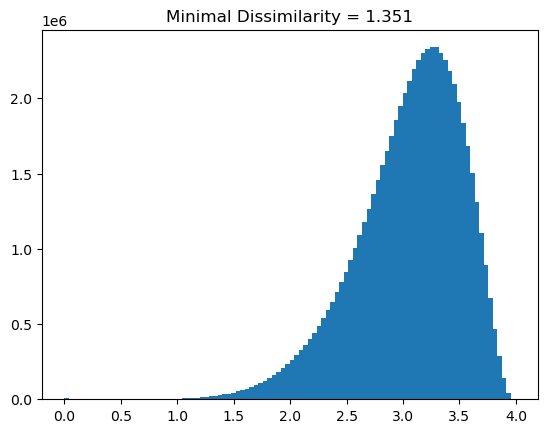

In [8]:
adp_min = np.quantile(adp_dissimilarity_matrix.flatten(), 0.002)

plt.hist(adp_dissimilarity_matrix.flatten(), bins = 100)
plt.title(f"Minimal Dissimilarity = {adp_min:.3f}")
plt.show()

adp_thresh = 0.2
adp_dissimilarity_matrix_shifted = np.maximum(adp_dissimilarity_matrix - adp_min, adp_thresh)

### Optional: Visualize Dissimilarity Metric

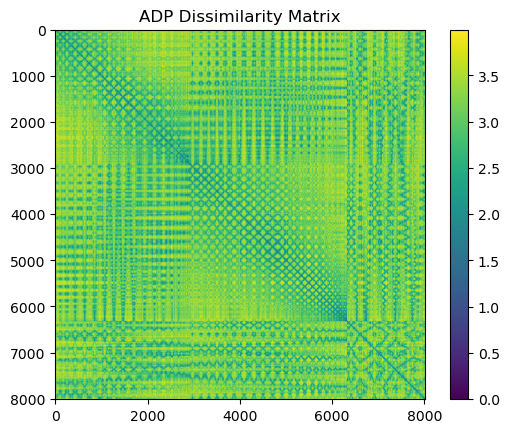

In [9]:
plt.imshow(adp_dissimilarity_matrix)
plt.title("ADP Dissimilarity Matrix")
plt.colorbar()
plt.show()

In [10]:
training_groundtruth_positions = []

for dataset in training_set:
    training_groundtruth_positions.append(dataset["cluster_positions"])

training_groundtruth_positions = np.concatenate(training_groundtruth_positions)

In [11]:
# Compute distances between groundtruth positions
groundtruth_distance_matrix = np.sqrt(np.sum((training_groundtruth_positions[np.newaxis,:,:] - training_groundtruth_positions[:,np.newaxis,:])**2, axis = -1))

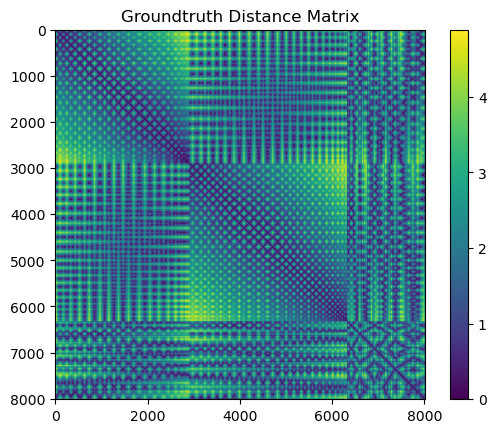

In [12]:
plt.imshow(groundtruth_distance_matrix)
plt.title("Groundtruth Distance Matrix")
plt.colorbar()
plt.show()

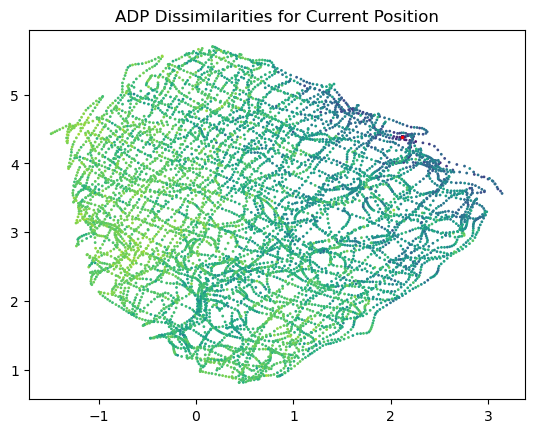

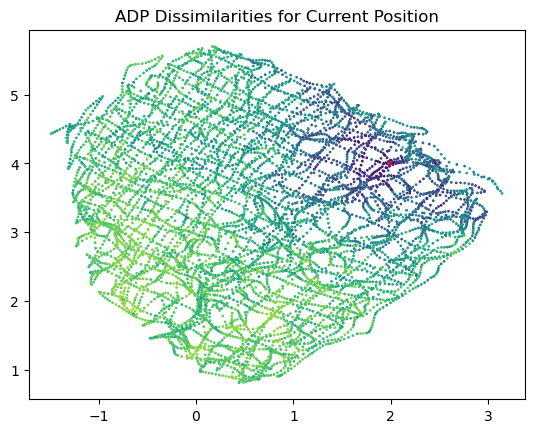

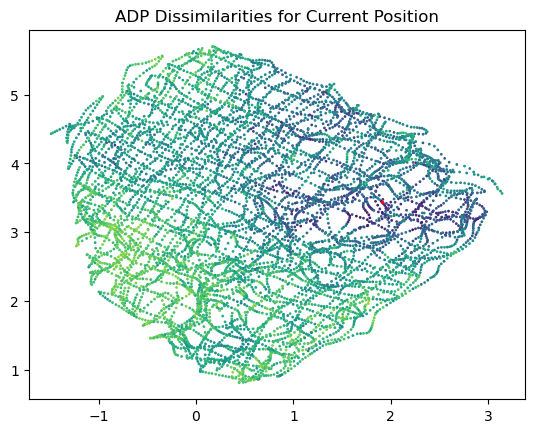

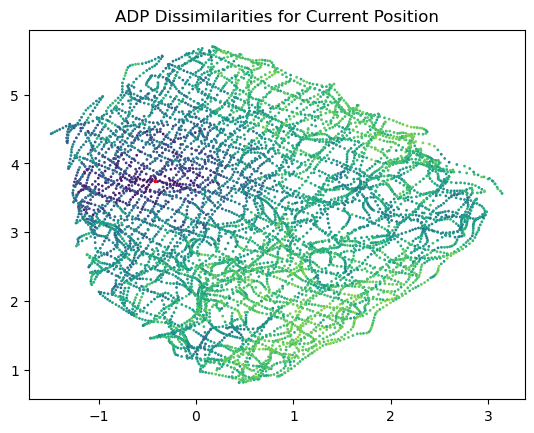

In [13]:
for sample_index in range(1, 2000, 500):
    plt.scatter(training_groundtruth_positions[:,0], training_groundtruth_positions[:,1], c = adp_dissimilarity_matrix_shifted[:,sample_index], s = 1, vmin = 0, vmax = 3)
    plt.scatter([training_groundtruth_positions[sample_index,0]], [training_groundtruth_positions[sample_index,1]], c = "r", s = 2)
    plt.title("ADP Dissimilarities for Current Target Position")
    plt.show()

## Fuse ADP and Time-based Dissimilarity Matrices

In [14]:
training_timestamps = []

for dataset in training_set:
    training_timestamps.append(dataset["cluster_timestamps"])

training_timestamps = np.concatenate(training_timestamps)

timestamp_dissimilarity_matrix = np.abs(np.subtract.outer(training_timestamps, training_timestamps))

In [15]:
# TODO: Choose good scaling factor!
scaling_factor = 0.02

dissimilarity_matrix_fused = np.minimum(adp_dissimilarity_matrix_shifted, timestamp_dissimilarity_matrix * scaling_factor)

## Geodesic Dissimilarity Matrix

In [16]:
n_neighbors = 20

nbrs_alg = NearestNeighbors(n_neighbors = n_neighbors, metric = "precomputed", n_jobs = -1)
nbrs = nbrs_alg.fit(dissimilarity_matrix_fused)
nbg = kneighbors_graph(nbrs, n_neighbors, metric = "precomputed", mode = "distance")

In [17]:
dissimilarity_matrix_geodesic = np.zeros((sample_count, sample_count), dtype = np.float32)

def shortest_path_worker(todo_queue, output_queue):
    while True:
        index = todo_queue.get()

        if index == -1:
            output_queue.put((-1, None))
            break

        d = dijkstra(nbg, directed = False, indices = index)
        output_queue.put((index, d))

with tqdm(total = sample_count**2) as pbar:
    todo_queue = mp.Queue()
    output_queue = mp.Queue()

    for i in range(sample_count):
        todo_queue.put(i)

    for i in range(mp.cpu_count()):
        todo_queue.put(-1)
        p = mp.Process(target = shortest_path_worker, args = (todo_queue, output_queue))
        p.start()

    finished_processes = 0
    while finished_processes != mp.cpu_count():
        i, d = output_queue.get()

        if i == -1:
            finished_processes = finished_processes + 1
        else:
            dissimilarity_matrix_geodesic[i,:] = d
            pbar.update(len(d))

  0%|          | 0/64192144 [00:00<?, ?it/s]

In [18]:
dissimilarity_matrix_geodesic_shifted = np.maximum(dissimilarity_matrix_geodesic - adp_thresh, 0.0)

### Scale dissimilarity matrix to "meters"

Scale all dissimilarities so that they can be interpreted as a distance in meters. Use classical location estimates for this purpose.

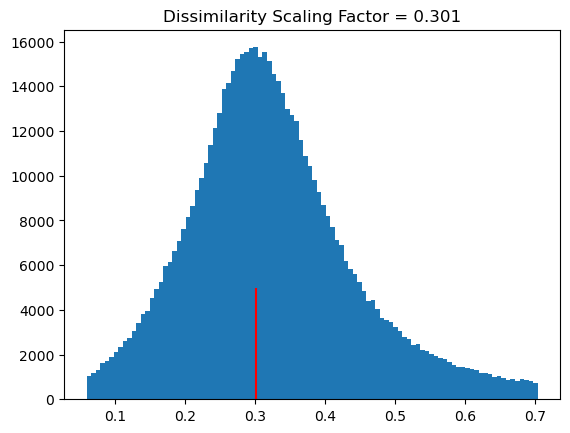

In [19]:
def compute_scaling_factor_meters(scaling_nth_reduction = 10):
    classical_positions_reduced = np.concatenate([dataset["triangulation_position_estimates"] for dataset in training_set])[::scaling_nth_reduction]
    dissimilarity_matrix_reduced = dissimilarity_matrix_geodesic_shifted[::scaling_nth_reduction, ::scaling_nth_reduction]
    classical_distance_matrix = np.sqrt(np.sum((classical_positions_reduced[np.newaxis,:] - classical_positions_reduced[:,np.newaxis])**2, axis = -1))
    
    dissimilarity_unit_meters = np.full_like(dissimilarity_matrix_reduced, np.nan)
    np.divide(dissimilarity_matrix_reduced, classical_distance_matrix, out = dissimilarity_unit_meters, where = classical_distance_matrix != 0)
    dissimilarity_unit_meters = dissimilarity_unit_meters.flatten()
    scaling_factor_meters = np.median(dissimilarity_unit_meters[np.isfinite(dissimilarity_unit_meters)])
    
    ratios = dissimilarity_unit_meters.flatten()
    ratios = ratios[~np.isnan(ratios)]
    
    occurences, edges, patches = plt.hist(ratios, bins = 100, range = (np.quantile(ratios, 0.01), np.quantile(ratios, 0.95)))
    bin_centers = edges[:-1] + np.diff(edges) / 2.
    max_bin = np.argmax(occurences)
    scaling_factor_meters = bin_centers[max_bin]
    plt.vlines(scaling_factor_meters, 0, 5000, "r")
    plt.title(f"Dissimilarity Scaling Factor = {scaling_factor_meters:.3f}")
    plt.show()

    return scaling_factor_meters

dissimilarity_matrix_geodesic_meters = dissimilarity_matrix_geodesic_shifted / compute_scaling_factor_meters()

### Store Dissimilarity Matrix to File

In [20]:
!mkdir -p dissimilarity_matrices
np.save(os.path.join("dissimilarity_matrices", espargos_0007.hash_dataset_names(training_set) + ".geodesic_meters.npy"), dissimilarity_matrix_geodesic_meters)

### Optional: Visualize and Compare Dissimilarity Metrics

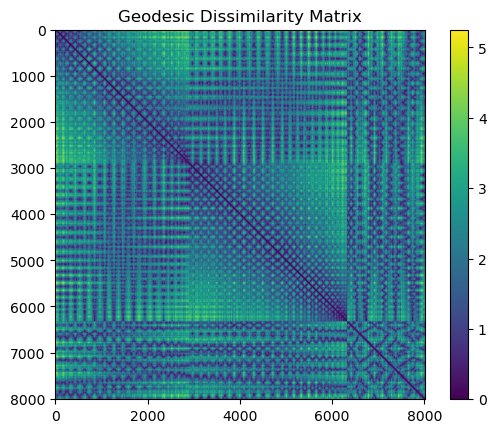

In [21]:
plt.imshow(dissimilarity_matrix_geodesic_meters)
plt.title("Geodesic Dissimilarity Matrix")
plt.colorbar()
plt.show()

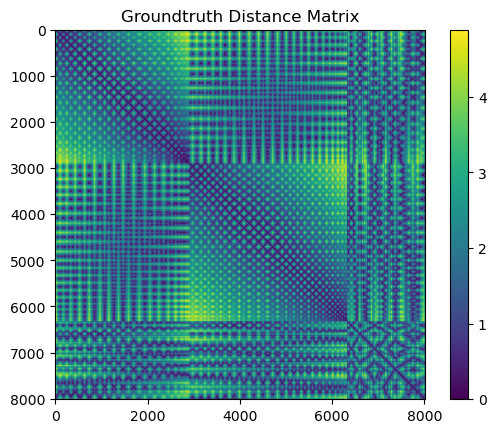

In [22]:
plt.imshow(groundtruth_distance_matrix)
plt.title("Groundtruth Distance Matrix")
plt.colorbar()
plt.show()

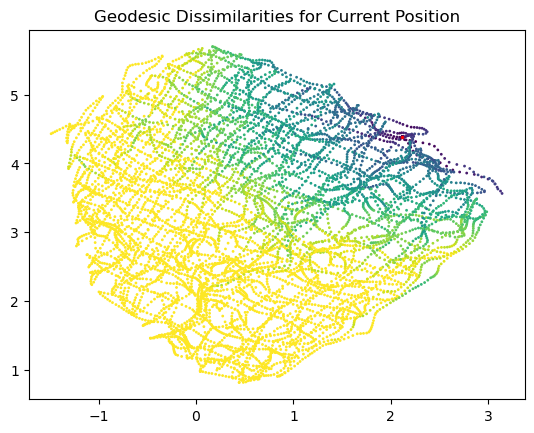

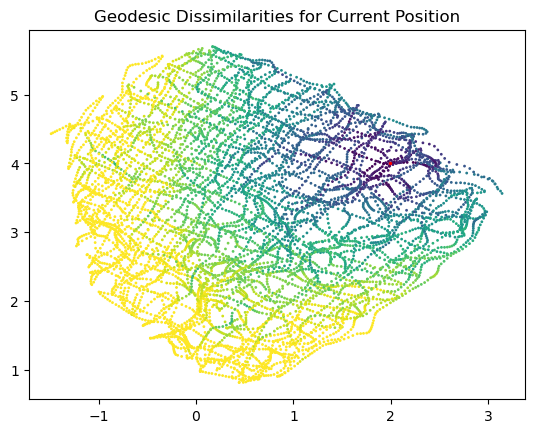

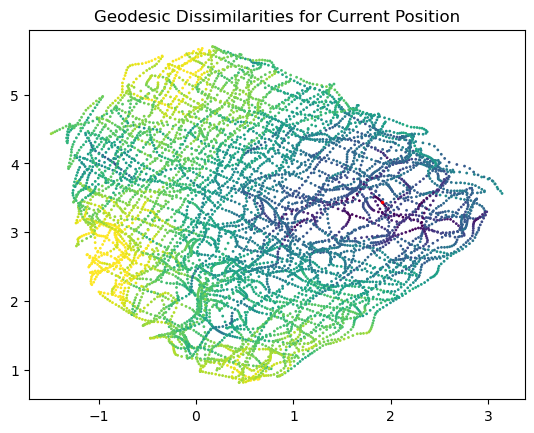

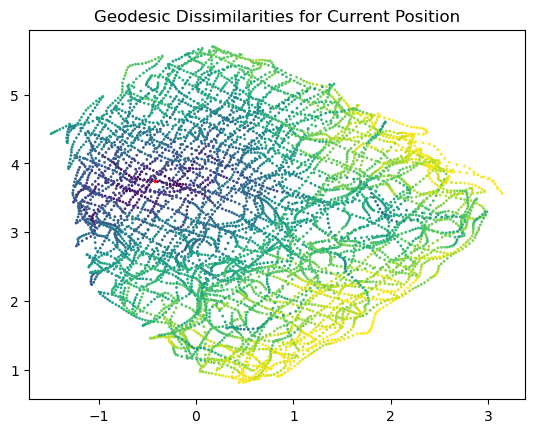

In [23]:
for sample_index in range(1, 2000, 500):
    plt.scatter(training_groundtruth_positions[:,0], training_groundtruth_positions[:,1], c = dissimilarity_matrix_geodesic_meters[:,sample_index], s = 1, vmin = 0, vmax = 3)
    plt.scatter([training_groundtruth_positions[sample_index,0]], [training_groundtruth_positions[sample_index,1]], c = "r", s = 2)
    plt.title("Geodesic Dissimilarities for Current Target Position")
    plt.show()

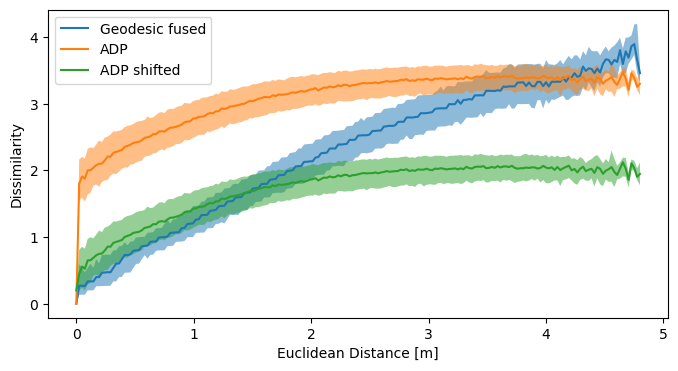

In [24]:
def plot_dissimilarity_over_euclidean_distance(dissimilarity_matrix, distance_matrix, label = None):
    nth_reduction = 10
    dissimilarities_flat = dissimilarity_matrix[::nth_reduction, ::nth_reduction].flatten()
    distances_flat = distance_matrix[::nth_reduction, ::nth_reduction].flatten()

    max_distance = np.max(distances_flat)
    bins = np.linspace(0, max_distance, 200)
    bin_indices = np.digitize(distances_flat, bins)

    bin_medians = np.zeros(len(bins) - 1)
    bin_25_perc = np.zeros(len(bins) - 1)
    bin_75_perc = np.zeros(len(bins) - 1)
    for i in range(1, len(bins)):
        bin_values = dissimilarities_flat[bin_indices == i]
        bin_25_perc[i - 1], bin_medians[i - 1], bin_75_perc[i - 1] = np.percentile(bin_values, [25, 50, 75])

    plt.plot(bins[:-1], bin_medians, label = label)
    plt.fill_between(bins[:-1], bin_25_perc, bin_75_perc, alpha=0.5)

plt.figure(figsize = (8,4))

plot_dissimilarity_over_euclidean_distance(dissimilarity_matrix_geodesic_meters, groundtruth_distance_matrix, "Geodesic fused")
plot_dissimilarity_over_euclidean_distance(adp_dissimilarity_matrix, groundtruth_distance_matrix, "ADP")
plot_dissimilarity_over_euclidean_distance(adp_dissimilarity_matrix_shifted, groundtruth_distance_matrix, "ADP shifted")

plt.legend()
plt.xlabel("Euclidean Distance [m]")
plt.ylabel("Dissimilarity")
plt.show()